### TODO

- Download OWGR historical information
- Apply OWGR as strength of field feature
- Gather golfer summary statistics as features
- Update score prediction for the hole after each shot?
- Gather SG stats for golfer and merge with course features

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import time
import math
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from sklearn import linear_model
from sklearn import ensemble

from sklearn import metrics

%matplotlib inline
pd.set_option('display.max_columns', None)

In [16]:
TRAIN_FILE = './data/all-golfers-holes-train.csv'
VALIDATION_FILE = './data/all-golfers-holes-validation.csv'
TEST_FILE = './data/all-golfers-holes-test.csv'

TRAIN_FILE = './data/justin-thomas-holes-train.csv'
VALIDATION_FILE = './data/justin-thomas-holes-validation.csv'
TEST_FILE = './data/justin-thomas-holes-test.csv'

In [3]:
df = pd.read_csv(TRAIN_FILE, index_col=None)
df.head()

,Year,PlayerNumber,HoleNumber,CourseNumber,Course,AvgPuttsGained,AvgSGT2G,AvgSGTotal,AvgOTTSG,AvgAppSG,AvgARGSG,DrivingDistanceAvg,DrivingAccuracyAvg,App5075ftAvg,App75100ftAvg,App100125ftAvg,App50125ftAvg,App125150ftAvg,App150175ftAvg,App175200ftAvg,App200ftAvg,AvgGIR,AvgProximityToHole,AvgScramblingProximityToHole,AvgSandProximityToHole,PuttingInside5Ft,PuttingInside10Ft,Putting5Ft10Ft,Putting4Ft8Ft,Putting10Ft15Ft,Putting15Ft20Ft,Putting20Ft25Ft,PuttingOver10Ft,PuttingOver25Ft,Yardage,Par,FairwayHeight,GreenHeight,RoughHeight,Stimp,FwyWidth250,FwyWidth275,FwyWidth300,FwyWidth325,FwyWidth350,Score
0,2016,35532,1,538,TPC Summerlin,-0.069333,-0.253889,-0.323159,-0.314968,0.235810,-0.174524,282.271591,0.534091,16.201417,16.164980,16.952260,16.649134,22.972424,25.993881,29.483239,46.695665,0.616402,33.832962,8.788962,11.659822,1.044706,0.858963,1.795031,0.684411,0.278689,0.207407,0.134146,0.167742,0.063636,412,4,0.42,0.12,2.75,12.0,26,29,31,34,36,4
1,2016,34264,1,538,TPC Summerlin,0.202560,0.099626,0.302275,0.402670,0.274846,-0.577879,291.863779,0.606299,14.342158,16.679987,20.575297,18.857406,22.195766,25.516959,32.710688,47.436202,0.683761,34.285514,10.076285,10.481842,1.029624,0.882812,1.718182,0.710027,0.300000,0.224044,0.076389,0.153392,0.054762,409,4,0.42,0.12,2.75,12.0,26,29,31,34,36,4
2,2016,35300,1,538,TPC Summerlin,0.300833,-0.415788,-0.114894,0.037470,-0.295348,-0.157818,300.278742,0.449024,18.553882,19.715986,17.985727,18.694326,26.034052,27.324766,34.850386,49.145612,0.624579,37.766226,9.273508,9.252663,1.042986,0.865463,1.736842,0.714286,0.348387,0.200000,0.219780,0.172414,0.048951,409,4,0.42,0.12,2.75,12.0,26,29,31,34,36,4
3,2016,35532,1,538,TPC Summerlin,-0.069333,-0.253889,-0.323159,-0.314968,0.235810,-0.174524,282.271591,0.534091,16.201417,16.164980,16.952260,16.649134,22.972424,25.993881,29.483239,46.695665,0.616402,33.832962,8.788962,11.659822,1.044706,0.858963,1.795031,0.684411,0.278689,0.207407,0.134146,0.167742,0.063636,409,4,0.42,0.12,2.75,12.0,26,29,31,34,36,3
4,2016,35732,1,538,TPC Summerlin,0.299395,-0.615047,-0.315535,-0.015163,-0.262023,-0.337651,284.880399,0.594684,13.933600,18.535714,19.642578,19.124985,26.497062,29.498664,34.874153,46.689031,0.633075,35.288574,8.720122,12.165075,1.036332,0.880299,1.585938,0.666667,0.269231,0.194030,0.096774,0.141204,0.070352,409,4,0.42,0.12,2.75,12.0,26,29,31,34,36,3


In [15]:
def fix_percentage_over(num):
    if num > 1:
        return 1/num
    else:
        return num

In [37]:
def load_and_process_data(file):
    df = pd.read_csv(file, index_col=None)
    
    df.drop(
        columns=['Year', 'PlayerNumber', 'HoleNumber', 'CourseNumber', 'Course'],
        axis=1,
        inplace=True
    )
    
    df.drop(
        columns=['AvgEagles', 'AvgBirdies', 'AvgPars', 'AvgBogies', 'AvgDoubles', 'AvgOthers'],
        axis=1,
        inplace=True
    )
    
    # check percentages for over 100% and fix
    df['DrivingAccuracyAvg'] = df['DrivingAccuracyAvg'].apply(fix_percentage_over)
    df['AvgGIR'] = df['AvgGIR'].apply(fix_percentage_over)
    df['PuttingInside5Ft'] = df['PuttingInside5Ft'].apply(fix_percentage_over)
    df['PuttingInside10Ft'] = df['PuttingInside10Ft'].apply(fix_percentage_over)
    df['Putting5Ft10Ft'] = df['Putting5Ft10Ft'].apply(fix_percentage_over)
    df['Putting4Ft8Ft'] = df['Putting4Ft8Ft'].apply(fix_percentage_over)
    df['Putting10Ft15Ft'] = df['Putting10Ft15Ft'].apply(fix_percentage_over)
    df['Putting15Ft20Ft'] = df['Putting15Ft20Ft'].apply(fix_percentage_over)
    df['Putting20Ft25Ft'] = df['Putting20Ft25Ft'].apply(fix_percentage_over)
    df['PuttingOver10Ft'] = df['PuttingOver10Ft'].apply(fix_percentage_over)
    df['PuttingOver25Ft'] = df['PuttingOver25Ft'].apply(fix_percentage_over)
    
    # drop nan
    df.dropna(inplace=True)
    
    return df

In [38]:
def split_data(df):
    #return X, y
    return df[df.columns[:-1]], df['Score']

In [39]:
def normalize_data(X):
    cols = X.columns
    return pd.DataFrame(MinMaxScaler().fit_transform(X), columns=cols)

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def multicollinearity_check(X, thresh=5.0):
    data_type = X.dtypes
    # print(type(data_type))
    int_cols = \
    X.select_dtypes(include=['int', 'int16', 'int32', 'int64', 'float', 'float16', 'float32', 'float64']).shape[1]
    total_cols = X.shape[1]
    try:
        if int_cols != total_cols:
            raise Exception('All the columns should be integer or float, for multicollinearity test.')
        else:
            variables = list(range(X.shape[1]))
            dropped = True
            print('''\n\nThe VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.\n\n''')
            while dropped:
                dropped = False
                vif = [variance_inflation_factor(X.iloc[:, variables].values, ix) for ix in variables]
                print('\n\nvif is: ', vif)
                maxloc = vif.index(max(vif))
                if max(vif) > thresh:
                    print('dropping \'' + X.iloc[:, variables].columns[maxloc] + '\' at index: ' + str(maxloc))
                    # del variables[maxloc]
                    X.drop(X.columns[variables[maxloc]], 1, inplace=True)
                    variables = list(range(X.shape[1]))
                    dropped = True

            print('\n\nRemaining variables:\n')
            print(X.columns[variables])
            # return X.iloc[:,variables]
            return X
    except Exception as e:
        print('Error caught: ', e)

In [57]:
df_train = load_and_process_data(TRAIN_FILE)
df_validation = load_and_process_data(VALIDATION_FILE)
#df_test = load_and_process_data(TEST_FILE)
df_train.head()

,AvgPuttsGained,AvgSGT2G,AvgSGTotal,AvgOTTSG,AvgAppSG,AvgARGSG,DrivingDistanceAvg,DrivingAccuracyAvg,App5075ftAvg,App75100ftAvg,App100125ftAvg,App50125ftAvg,App125150ftAvg,App150175ftAvg,App175200ftAvg,App200ftAvg,AvgGIR,AvgProximityToHole,AvgScramblingProximityToHole,AvgSandProximityToHole,PuttingInside5Ft,PuttingInside10Ft,Putting5Ft10Ft,Putting4Ft8Ft,Putting10Ft15Ft,Putting15Ft20Ft,Putting20Ft25Ft,PuttingOver10Ft,PuttingOver25Ft,Yardage,Par,FairwayHeight,GreenHeight,RoughHeight,Stimp,FwyWidth250,FwyWidth275,FwyWidth300,FwyWidth325,FwyWidth350,Score
0,-0.185013,0.505507,0.320453,0.029067,0.493667,-0.017453,293.604762,0.534286,14.213,19.695299,18.040868,18.260482,22.183331,24.792382,31.326881,44.423923,0.657037,35.287862,8.578867,9.810045,0.971163,0.880661,0.572785,0.66879,0.247826,0.184211,0.102564,0.136476,0.042345,411,4,0.5,0.9,2.25,11.0,25,27,30,32,35,4
1,-0.185013,0.505507,0.320453,0.029067,0.493667,-0.017453,293.604762,0.534286,14.213,19.695299,18.040868,18.260482,22.183331,24.792382,31.326881,44.423923,0.657037,35.287862,8.578867,9.810045,0.971163,0.880661,0.572785,0.66879,0.247826,0.184211,0.102564,0.136476,0.042345,409,4,0.5,0.9,2.25,11.0,25,27,30,32,35,4
2,-0.185013,0.505507,0.320453,0.029067,0.493667,-0.017453,293.604762,0.534286,14.213,19.695299,18.040868,18.260482,22.183331,24.792382,31.326881,44.423923,0.657037,35.287862,8.578867,9.810045,0.971163,0.880661,0.572785,0.66879,0.247826,0.184211,0.102564,0.136476,0.042345,420,4,0.5,0.9,2.25,11.0,25,27,30,32,35,5
3,-0.185013,0.505507,0.320453,0.029067,0.493667,-0.017453,293.604762,0.534286,14.213,19.695299,18.040868,18.260482,22.183331,24.792382,31.326881,44.423923,0.657037,35.287862,8.578867,9.810045,0.971163,0.880661,0.572785,0.66879,0.247826,0.184211,0.102564,0.136476,0.042345,395,4,0.3,0.1,3.00,12.5,26,28,31,33,36,4
4,-0.185013,0.505507,0.320453,0.029067,0.493667,-0.017453,293.604762,0.534286,14.213,19.695299,18.040868,18.260482,22.183331,24.792382,31.326881,44.423923,0.657037,35.287862,8.578867,9.810045,0.971163,0.880661,0.572785,0.66879,0.247826,0.184211,0.102564,0.136476,0.042345,394,4,0.3,0.1,3.00,12.5,26,28,31,33,36,4


In [59]:
df_train_2 = multicollinearity_check(df_train)
set(df_train_2.columns).difference(set(df_train.columns))



The VIF calculator will now iterate through the features and calculate their respective values.
            It shall continue dropping the highest VIF features until all the features have VIF less than the threshold of 5.




vif is:  [1.5471689001416112e-26, 9.200521617275647e-26, 8.437288332366375e-26, 2.147089015866277e-25, 4.1988804271620345e-27, 1.2980479225745903e-27, 2.655104898240927e-26, 2.2108621442462452e-26, 4.2377688300147014e-26, 1.613381174030784e-22, 1.1308202342699145e-25, 1.2261505421123738e-24, 3.573679559765454e-26, 0.0, 0.0, 0.0, 2.0533491761794928e-26, 0.03702193981536986, 3.2991640221507537e-26, 6.566553272117657e-26, 2.4716644323817576e-25, 1.6101552116691863e-25, 1.1964850005887638e-25, 1.5819318823276354e-25, 0.0, 1.764875996530498e-26, 2.926849703117724e-25, 1.4642393906377082e-25, 3.1735110884167873e-26, 2.649244597083838, 2.9842890514467233, 1.1572496687079936, 2.0234291128090804, 2.136027319706056, 3.8364462194112963, 2.469456855340466, 1.589331739309161

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\regression\linear_model.py:1543: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


set()

In [41]:
print('Training Shape', df_train.shape)
print('Validation Shape', df_validation.shape)
#print('Test Shape', df_test.shape)

Training Shape (1544, 41)
Validation Shape (1436, 41)


In [42]:
X_train, y_train = split_data(df_train)
X_validation, y_validation = split_data(df_validation)
#X_test, y_test = split_data(df_test)

print('Training X Shape', X_train.shape)
print('Training y Shape', y_train.shape)
print('Validation X Shape', X_validation.shape)
print('Validation y Shape', y_validation.shape)
#print('Test X Shape', X_test.shape)
#print('Test y Shape', y_test.shape)

Training X Shape (1544, 40)
Training y Shape (1544,)
Validation X Shape (1436, 40)
Validation y Shape (1436,)


In [43]:
X_train = normalize_data(X_train)
X_train.head()

,AvgPuttsGained,AvgSGT2G,AvgSGTotal,AvgOTTSG,AvgAppSG,AvgARGSG,DrivingDistanceAvg,DrivingAccuracyAvg,App5075ftAvg,App75100ftAvg,App100125ftAvg,App50125ftAvg,App125150ftAvg,App150175ftAvg,App175200ftAvg,App200ftAvg,AvgGIR,AvgProximityToHole,AvgScramblingProximityToHole,AvgSandProximityToHole,PuttingInside5Ft,PuttingInside10Ft,Putting5Ft10Ft,Putting4Ft8Ft,Putting10Ft15Ft,Putting15Ft20Ft,Putting20Ft25Ft,PuttingOver10Ft,PuttingOver25Ft,Yardage,Par,FairwayHeight,GreenHeight,RoughHeight,Stimp,FwyWidth250,FwyWidth275,FwyWidth300,FwyWidth325,FwyWidth350
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.611607,0.5,1.0,1.000000,0.45,0.758621,0.694444,0.710526,0.731707,0.744186,0.760870
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608631,0.5,1.0,1.000000,0.45,0.758621,0.694444,0.710526,0.731707,0.744186,0.760870
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.625000,0.5,1.0,1.000000,0.45,0.758621,0.694444,0.710526,0.731707,0.744186,0.760870
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.587798,0.5,0.6,0.111111,0.60,0.862069,0.722222,0.736842,0.756098,0.767442,0.782609
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.586310,0.5,0.6,0.111111,0.60,0.862069,0.722222,0.736842,0.756098,0.767442,0.782609


In [44]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
rf_reg.score(X_validation, y_validation)

-1.5051544272740713

In [45]:
feature_importances = pd.DataFrame(rf_reg.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
Par,0.350941
Yardage,0.344297
RoughHeight,0.061444
Stimp,0.052070
FairwayHeight,0.040539
GreenHeight,0.034155
FwyWidth275,0.028674
FwyWidth350,0.025654
FwyWidth325,0.024758
FwyWidth300,0.019134


In [46]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg.score(X_validation, y_validation)

0.17200557103064068

In [47]:
df_train.corr()['Score']

AvgPuttsGained                  3.172651e-17
AvgSGT2G                       -3.069059e-16
AvgSGTotal                     -4.285325e-16
AvgOTTSG                        3.069059e-16
AvgAppSG                       -1.460200e-16
AvgARGSG                       -1.722737e-16
DrivingDistanceAvg              1.452779e-16
DrivingAccuracyAvg              5.345119e-16
App5075ftAvg                   -2.644032e-16
App75100ftAvg                  -2.143432e-16
App100125ftAvg                  6.025355e-16
App50125ftAvg                  -1.435696e-16
App125150ftAvg                 -3.547153e-16
App150175ftAvg                  2.544006e-16
App175200ftAvg                 -2.544006e-16
App200ftAvg                    -2.289375e-16
AvgGIR                         -7.809075e-17
AvgProximityToHole             -2.433081e-16
AvgScramblingProximityToHole    1.435696e-16
AvgSandProximityToHole          1.327085e-16
PuttingInside5Ft               -8.667134e-17
PuttingInside10Ft              -3.371921e-16
Putting5Ft

In [48]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Poisson
from statsmodels.genmod.cov_struct import (Exchangeable,Independence,Autoregressive)

fam = Poisson()
ind = Independence()

col_list = [col for col in df_train.columns if col != 'Score']
poisson_formula = ' + '.join(col_list)

model = GEE.from_formula("Score ~ " + poisson_formula, groups="Par", data=df_train, cov_struct=ind, family=fam)
result = model.fit()
result.summary()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1397: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                       Score   No. Observations:                 1544
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                 267
                      Estimating Equations   Max. cluster size:                 935
Family:                            Poisson   Mean cluster size:               514.7
Dependence structure:         Independence   Num. iterations:                     9
Date:                     Thu, 21 Mar 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:42:55
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -7.9605   3.21e+05  -2.48e-05      1.000    -6.3e+05     6.3e+05
AvgPuttsGained                  23.2030   2.53e+06   9.16e-06      1.000   -4.97e+06    4.97e+06
AvgSGT2G                         9.8877   1.05e+06   9.39e-06      1.000   -2.06e+06    2.06e+06
AvgSGTotal                      10.5638        nan        nan        nan         nan         nan
AvgOTTSG                       113.5499        nan        nan        nan         nan         nan
AvgAppSG                       -10.1688        nan        nan        nan         nan         nan
AvgARGSG                       195.3401   6.98e+06    2.8e-05      1.000   -1.37e+07    1.37e+07
DrivingDistanceAvg              -0.0049        nan        nan        nan         nan         nan
DrivingAccuracyAvg              -5.1037    4.3e+05  -1.19e-05      1.000   -8.43e+05    8.43e+05
App5075ftAvg                    -0.1005        nan        nan        nan         nan         nan
App75100ftAvg                   -0.2320        nan        nan        nan         nan         nan
App100125ftAvg                  -0.1870        nan        nan        nan         nan         nan
App50125ftAvg                    0.1265        nan        nan        nan         nan         nan
App125150ftAvg                  -0.1234        nan        nan        nan         nan         nan
App150175ftAvg                   0.6755   5767.489      0.000      1.000   -1.13e+04    1.13e+04
App175200ftAvg                  -0.2580   1.05e+04  -2.46e-05      1.000   -2.06e+04    2.06e+04
App200ftAvg                      0.1572        nan        nan        nan         nan         nan
AvgGIR                          -2.8179        nan        nan        nan         nan         nan
AvgProximityToHole               0.0915   3846.858   2.38e-05      1.000   -7539.611    7539.794
AvgScramblingProximityToHole    -1.5000        nan        nan        nan         nan         nan
AvgSandProximityToHole          -0.6798        nan        nan        nan         nan         nan
PuttingInside5Ft                -0.4242        nan        nan        nan         nan         nan
PuttingInside10Ft                2.5723      2e+05   1.28e-05      1.000   -3.93e+05    3.93e+05
Putting5Ft10Ft                  24.9795   3.12e+05      8e-05      1.000   -6.12e+05    6.12e+05
Putting4Ft8Ft                    1.3493        nan        nan        nan         nan         nan
Putting10Ft15Ft                  8.3965        nan        nan        nan         nan         nan
Putting15Ft20Ft                -24.4565   1.92e+06  -1.27e-05      1.000   -3.77e+06    3.77e+06
Putting20Ft25Ft                 21.0088   1.71e+06   1.23e-05      1.000   -3.35e+06    3.35e+06
PuttingOver10Ft                 37.9849   1.93e+06   1.97e-05      1.000   -3.78e+06    3.78e+06
PuttingO

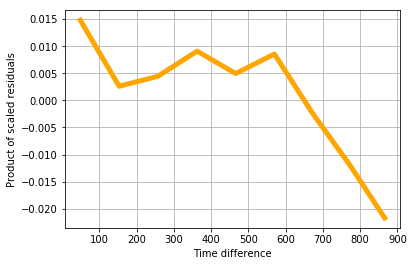

In [49]:
fig = result.plot_isotropic_dependence()
plt.grid(True)

Text(0,0.5,'Log mean')

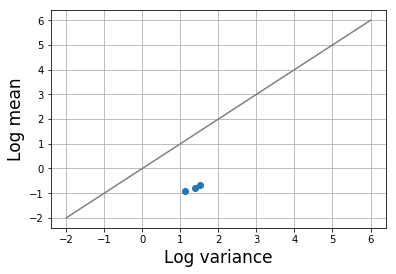

In [50]:
yg = model.cluster_list(np.asarray(df_train["Score"]))
ymn = [x.mean() for x in yg]
yva = [x.var() for x in yg]
plt.grid(True)
plt.plot(np.log(ymn), np.log(yva), 'o')
plt.plot([-2, 6], [-2, 6], '-', color='grey')
plt.xlabel("Log variance", size=17)
plt.ylabel("Log mean", size=17)

In [51]:
fam = Poisson()
ex = Exchangeable()
model2 = GEE.from_formula("Score ~ " + poisson_formula, groups="Par", data=df_train, cov_struct=ex, family=fam)
result2 = model.fit()
result2.summary()

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1397: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_robust))
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                       Score   No. Observations:                 1544
Model:                                 GEE   No. clusters:                        3
Method:                        Generalized   Min. cluster size:                 267
                      Estimating Equations   Max. cluster size:                 935
Family:                            Poisson   Mean cluster size:               514.7
Dependence structure:         Independence   Num. iterations:                     9
Date:                     Thu, 21 Mar 2019   Scale:                           1.000
Covariance type:                    robust   Time:                         13:44:43
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -7.9605   3.21e+05  -2.48e-05      1.000    -6.3e+05     6.3e+05
AvgPuttsGained                  23.2030   2.53e+06   9.16e-06      1.000   -4.97e+06    4.97e+06
AvgSGT2G                         9.8877   1.05e+06   9.39e-06      1.000   -2.06e+06    2.06e+06
AvgSGTotal                      10.5638        nan        nan        nan         nan         nan
AvgOTTSG                       113.5499        nan        nan        nan         nan         nan
AvgAppSG                       -10.1688        nan        nan        nan         nan         nan
AvgARGSG                       195.3401   6.98e+06    2.8e-05      1.000   -1.37e+07    1.37e+07
DrivingDistanceAvg              -0.0049        nan        nan        nan         nan         nan
DrivingAccuracyAvg              -5.1037    4.3e+05  -1.19e-05      1.000   -8.43e+05    8.43e+05
App5075ftAvg                    -0.1005        nan        nan        nan         nan         nan
App75100ftAvg                   -0.2320        nan        nan        nan         nan         nan
App100125ftAvg                  -0.1870        nan        nan        nan         nan         nan
App50125ftAvg                    0.1265        nan        nan        nan         nan         nan
App125150ftAvg                  -0.1234        nan        nan        nan         nan         nan
App150175ftAvg                   0.6755   5767.489      0.000      1.000   -1.13e+04    1.13e+04
App175200ftAvg                  -0.2580   1.05e+04  -2.46e-05      1.000   -2.06e+04    2.06e+04
App200ftAvg                      0.1572        nan        nan        nan         nan         nan
AvgGIR                          -2.8179        nan        nan        nan         nan         nan
AvgProximityToHole               0.0915   3846.858   2.38e-05      1.000   -7539.611    7539.794
AvgScramblingProximityToHole    -1.5000        nan        nan        nan         nan         nan
AvgSandProximityToHole          -0.6798        nan        nan        nan         nan         nan
PuttingInside5Ft                -0.4242        nan        nan        nan         nan         nan
PuttingInside10Ft                2.5723      2e+05   1.28e-05      1.000   -3.93e+05    3.93e+05
Putting5Ft10Ft                  24.9795   3.12e+05      8e-05      1.000   -6.12e+05    6.12e+05
Putting4Ft8Ft                    1.3493        nan        nan        nan         nan         nan
Putting10Ft15Ft                  8.3965        nan        nan        nan         nan         nan
Putting15Ft20Ft                -24.4565   1.92e+06  -1.27e-05      1.000   -3.77e+06    3.77e+06
Putting20Ft25Ft                 21.0088   1.71e+06   1.23e-05      1.000   -3.35e+06    3.35e+06
PuttingOver10Ft                 37.9849   1.93e+06   1.97e-05      1.000   -3.78e+06    3.78e+06
PuttingO

In [52]:
time = np.kron(np.ones(df_train.shape[0]/4), (0,1,2,3))
fam = Poisson()
ar = Autoregressive()
ar.dep_params = 0.4
model3 = GEE.from_formula("Score ~ " + poisson_formula, groups="Par", data=df_train, time=time, cov_struct=ar, family=fam)
result3 = model3.fit(start_params=result2.params)
print(result3.summary())
print(ar.summary())
print("scale=%.2f" % (result2.scale))

TypeError: 'float' object cannot be interpreted as an integer